# Économétrie pure

On veut valider empiriquement l'équation suivante : 
$$\phi_{t}^{i} = \frac{1}{c_{\phi}^{i}}(P^{i}-A^{i}(E_{t}^{i}-\Psi_{t}^{i}))$$
Avec : 
- $\phi_{t}^{i}$: Flux mensuel de communication environnementale au mois $t$ pour l'entreprise $i$.
- $c_{t}^{i}$: Coût marginal de communication.
- $E_{t}^{i}$: Score environnemental au mois $t$ pour l'entreprise $i$.
- $\Psi_{t}^{i}$: Valeur environnementale fondamentale de l'entreprise $i$ au mois $t$.


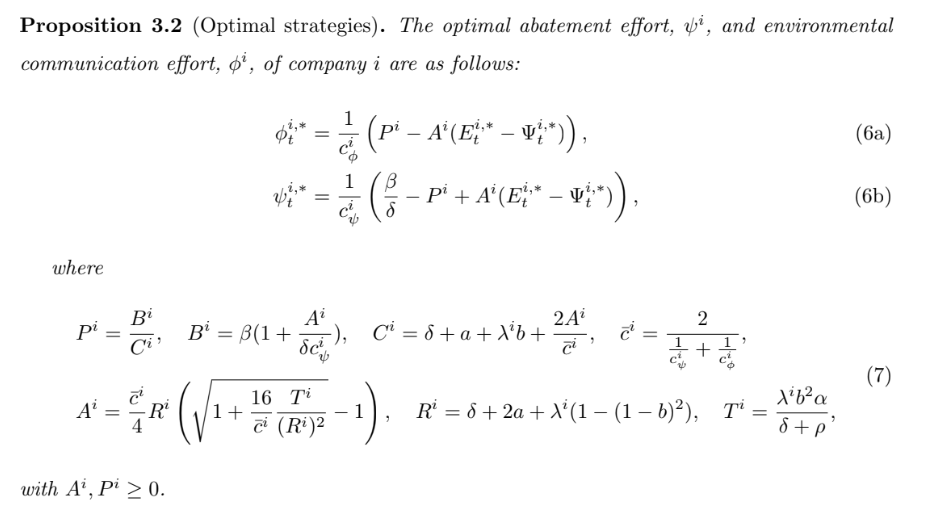

## 1st step

On cherche à construire un proxy $\hat{\phi}^{i}_{t}$ pour $\phi^{i}_{t}$. 


Nous construisons un score de communication environnementale, $\hat{\varepsilon}^{i}_{1,t}$, purifié de l'effet des controverses environnementales, défini comme les résidus de la régression Within de $Rep^{i}_{t}$ sur $Con^{i}_{t}$ avec des effets fixes dans le temps et pour l'entreprise, où $Con^{i}_{t}$ est instrumenté par $Con^{i}_{t-1}$ :
\begin{equation}
Rep^{i}_{t} = \alpha^{i}_{1,1} + \alpha_{1,2,t} + \beta_1 Con^{i,*}_{t} + \varepsilon^{i}_{1,t}
\end{equation}

où $Con^{i,*}_{t} = \hat{\beta}_2 Con^{i}_{t-1}$ est la prédiction de la régression suivante :
\begin{equation}
Con^{i}_{t} = \alpha^{i}_{2,1} + \alpha_{2,2,t} + \beta_2 Con^{i}_{t-1} + \varepsilon^{i}_{2,t}.
\end{equation}

--------------- TESTER PERTINENCE DE L'INSTRUMENT ----------------

Le test de pertinence de l'instrument $Con^{i}_{t}$ donne un $R^2$ de la régression de $Con^{i}_{t}$ sur $Con^{i}_{t-1}$ de 78,3\%. De plus, la condition d'exogénéité faible est satisfaite, assurant que les résidus de la régression 2SLS peuvent être utilisés pour construire un proxy du score de communication environnementale. Nous définissons alors un proxy du flux de communication environnementale, $\hat{\varphi}^{i}_{t}$, comme la première différence du score de communication environnementale :
\begin{equation}
\hat{\varphi}^{i}_{t} \equiv \hat{\varepsilon}^{i}_{1,t} - \hat{\varepsilon}^{i}_{1,t-1}.
\end{equation}

Ce proxy représente le flux de communication environnementale de l'entreprise i au mois t.

In [1]:
!pip3 install openpyxl
!pip3 install linearmodels
!pip3 install seaborn
import pandas as pd
import numpy as np
import linearmodels
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from linearmodels.panel import PanelOLS, FirstDifferenceOLS, compare, RandomEffects
from tqdm import tqdm
from linearmodels.panel.model import MissingValueWarning

warnings.filterwarnings('ignore', category=MissingValueWarning)

In [2]:
df = pd.read_pickle('data_pannels.pkl')

# Convertir la colonne 'Date' en type datetime
df['Date'] = pd.to_datetime(df['Date'])

df['ESG'] = df['ESG'].str.replace(',', '.').astype(float)


# Définir l'index sur les colonnes 'idEntreprise' et 'Date'
df.set_index(['idEntreprise', 'Date'], inplace=True)

df['Con_lag'] = df.groupby(level=0)['Controverse'].shift(1)

df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
1909         2009-01-01   -0.212564  52.887968  50.000000 -0.024961   
             2009-02-01   -0.130131  53.411459  66.666667 -0.027127   
             2009-03-01   -0.164780  53.368924  66.666667 -0.022612   
             2009-04-01   -0.231450  53.327240  66.666667 -0.024302   
             2009-05-01   -0.230980  53.286390  66.666667 -0.024861   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.446655  51.443093  50.000000 -0.930035   
             2023-01-01   -0.444577  51.439231  50.000000 -0.928834   
             2023-02-01   -0.458191  51.435447  50.000000 -0.925788   
             2023-03-01   -0.445543  51.431738  50.000000 -0.927918   
             2023-04-01   -0.443735  51.705881  50.000000 -0.923323   

                         Controverse GICS industry group  \
idEntreprise Date                                          
1909         2009-01-01          0.0       Capital Goods   
             2009-02-01          0.0       Capital Goods   
             2009-03-01          0.0       Capital Goods   
             2009-04-01          0.0       Capital Goods   
             2009-05-01          0.0       Capital Goods   
...                              ...                 ...   
18970        2022-12-01          0.0       Capital Goods   
             2023-01-01          0.0       Capital Goods   
             2023-02-01          0.0       Capital Goods   
             2023-03-01          0.0       Capital Goods   
             2023-04-01          0.0       Capital Goods   

                                                    GICS sub-industry  Con_lag  
idEntreprise Date                                                               
1909         2009-01-01                    Construction & Engineering      NaN  
             2009-02-01                    Construction & Engineering      0.0  
             2009-03-01                    Construction & Engineering      0.0  
             2009-04-01                    Construction & Engineering      0.0  
             2009-05-01                    Construction & Engineering      0.0  
...                                                               ...      ...  
18970        2022-12-01  Industrial Machinery & Supplies & Components      0.0  
             2023-01-01  Industrial Machinery & Supplies & Components      0.0  
             2023-02-01  Industrial Machinery & Supplies & Components      0.0  
             2023-03-01  Industrial Machinery & Supplies & Components      0.0  
             2023-04-01  Industrial Machinery & Supplies & Components      0.0  

[11696 rows x 8 columns]

In [3]:
# Sélectionnez les colonnes pertinentes pour le calcul de la corrélation
variables = ['score_comm', 'ESG', 'PFL', 'Controverse']
correlation_matrix = df[variables].corr()
correlation_matrix

,score_comm,ESG,PFL,Controverse
score_comm,1.000000,0.037513,-0.003518,0.013964
ESG,0.037513,1.000000,0.376492,0.080750
PFL,-0.003518,0.376492,1.000000,0.110408
Controverse,0.013964,0.080750,0.110408,1.000000


Malgré le fait que le score de communication environemental ait été créer à partir des variations de PFL, on observe une faible corrélation entre ces deux variables. Egalement la corrélation reste faible entre ce score de communication, et les autres variables

### Etape 1 : Construire la variable Con_star

#### Construction de Con_star

In [4]:
# Première étape: Régression de Con sur Con_lag avec effets fixes
first_stage_fix = PanelOLS(dependent=df['Controverse'], 
                       exog=df[['Con_lag']],
                       entity_effects=True, 
                       time_effects=True)
res_first_stage_fix = first_stage_fix.fit()

# Ajouter les valeurs ajustées à df
df['Con_star_fix'] = res_first_stage_fix.fitted_values

df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
1909         2009-01-01   -0.212564  52.887968  50.000000 -0.024961   
             2009-02-01   -0.130131  53.411459  66.666667 -0.027127   
             2009-03-01   -0.164780  53.368924  66.666667 -0.022612   
             2009-04-01   -0.231450  53.327240  66.666667 -0.024302   
             2009-05-01   -0.230980  53.286390  66.666667 -0.024861   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.446655  51.443093  50.000000 -0.930035   
             2023-01-01   -0.444577  51.439231  50.000000 -0.928834   
             2023-02-01   -0.458191  51.435447  50.000000 -0.925788   
             2023-03-01   -0.445543  51.431738  50.000000 -0.927918   
             2023-04-01   -0.443735  51.705881  50.000000 -0.923323   

                         Controverse GICS industry group  \
idEntreprise Date                                          
1909         2009-01-01          0.0       Capital Goods   
             2009-02-01          0.0       Capital Goods   
             2009-03-01          0.0       Capital Goods   
             2009-04-01          0.0       Capital Goods   
             2009-05-01          0.0       Capital Goods   
...                              ...                 ...   
18970        2022-12-01          0.0       Capital Goods   
             2023-01-01          0.0       Capital Goods   
             2023-02-01          0.0       Capital Goods   
             2023-03-01          0.0       Capital Goods   
             2023-04-01          0.0       Capital Goods   

                                                    GICS sub-industry  \
idEntreprise Date                                                       
1909         2009-01-01                    Construction & Engineering   
             2009-02-01                    Construction & Engineering   
             2009-03-01                    Construction & Engineering   
             2009-04-01                    Construction & Engineering   
             2009-05-01                    Construction & Engineering   
...                                                               ...   
18970        2022-12-01  Industrial Machinery & Supplies & Components   
             2023-01-01  Industrial Machinery & Supplies & Components   
             2023-02-01  Industrial Machinery & Supplies & Components   
             2023-03-01  Industrial Machinery & Supplies & Components   
             2023-04-01  Industrial Machinery & Supplies & Components   

                         Con_lag  Con_star_fix  
idEntreprise Date                               
1909         2009-01-01      NaN           NaN  
             2009-02-01      0.0           0.0  
             2009-03-01      0.0           0.0  
             2009-04-01      0.0           0.0  
             2009-05-01      0.0           0.0  
...                          ...           ...  
18970        2022-12-01      0.0           0.0  
             2023-01-01      0.0           0.0  
             2023-02-01      0.0           0.0  
             2023-03-01      0.0           0.0  
             2023-04-01      0.0           0.0  

[11696 rows x 9 columns]

#### Analyse de Con_star et de sa régression

In [5]:
print(res_first_stage_fix)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Controverse   R-squared:                        0.7134
Estimator:                   PanelOLS   R-squared (Between):              0.9735
No. Observations:               11628   R-squared (Within):               0.7271
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.7687
Time:                        10:25:46   Log-likelihood                -2.312e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   2.835e+04
Entities:                          68   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(1,11389)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):          2.835e+04
                            

Voici une explication des principaux éléments de la sortie :

        La variable dépendante (Dep. Variable) est 'Controverse'.
        Le coefficient de détermination (R-squared) est de 0.7213, ce qui signifie que le modèle explique environ 72.13 % de la variance de la variable dépendante.
        Le R-squared (Between) représente la proportion de variance expliquée par les variations entre les entités.
        Le R-squared (Within) représente la proportion de variance expliquée par les variations à l'intérieur des entités.
        Le R-squared (Overall) représente la proportion de variance expliquée par le modèle dans son ensemble.

    Informations sur l'estimation :
        Le nombre d'observations est de 12141 (on perds des estimations à cause de l'effet within.

    Statistiques de test :
        Le F-statistic est utilisé pour tester la significativité globale du modèle. Ici, il est de 3.08e+04 avec un P-value de 0.0000, indiquant que le modèle dans son ensemble est statistiquement significatif.
        Le F-statistic (robust) est une version robuste du F-statistic qui est moins sensible aux violations des hypothèses de base de la régression linéaire.
        Le F-test for Poolability est utilisé pour tester la validité des effets fixes. Le P-value de ce test est également très faible (0.0000), ce qui suggère que les effets fixes sont statistiquement significatifs.

    Estimations des paramètres :
        Le coefficient de la variable explicative 'Con_lag' est de 0.8551. Cela signifie que, toutes choses égales par ailleurs, une augmentation d'une unité de 'Con_lag' est associée à une augmentation de 0.8551 unité de 'Controverse'.
        Les erreurs standard fournissent une indication de la précision des estimations des coefficients.
        Les valeurs de T-statistic et de P-value permettent de tester l'importance individuelle des coefficients. Ici, la P-value associée à 'Con_lag' est très faible (0.0000), indiquant que ce coefficient est statistiquement significatif.

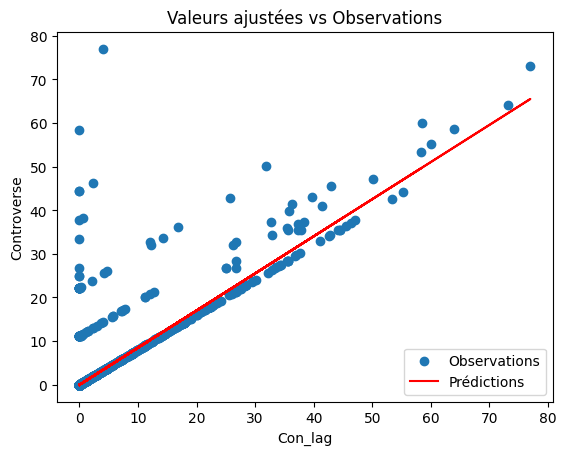

In [6]:
plt.scatter(df['Con_lag'], df['Controverse'], label='Observations')
plt.plot(df['Con_lag'], df['Con_star_fix'], color='red', label='Prédictions')
plt.xlabel('Con_lag')
plt.ylabel('Controverse')
plt.legend()
plt.title('Valeurs ajustées vs Observations')
plt.show()

In [7]:
# Calcul des critères R2 ajustés, AIC et BIC à la main

# Calcul du R2 ajusté
n = res_first_stage_fix.nobs
k = res_first_stage_fix.df_model
r2 = res_first_stage_fix.rsquared
r2_adjusted_fix = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

num_params_fix = res_first_stage_fix.params.shape[0]
nobs_fix = res_first_stage_fix.nobs
resid_ss_fix = np.sum(res_first_stage_fix.resids ** 2)
aic_fix = 2 * num_params_fix - 2 * np.log(resid_ss_fix)
bic_fix = np.log(nobs_fix) * num_params_fix - 2 * np.log(resid_ss_fix)

print("R2 ajusté:", r2_adjusted_fix)
print("AIC:", aic_fix)
print("BIC:", bic_fix)

R2 ajusté: 0.7073755552303121
AIC: -18.998710928186778
BIC: -11.637539666508012


Test de Hausman : Le test de Hausman est utilisé pour évaluer la spécification appropriée des modèles de régression dans lesquels il y a une incertitude sur le choix entre des effets fixes et des effets aléatoires. Plus spécifiquement, il est utilisé dans les modèles de panel pour déterminer si les effets fixes sont préférables aux effets aléatoires.

In [8]:
# Créer un modèle RandomEffects
random_effects_model = RandomEffects(df['Controverse'], df[['Con_lag']])

# Ajuster le modèle
res_random_effects = random_effects_model.fit()

# Comparer les estimations des effets fixes et des effets aléatoires
hausman_test = compare({'Effets Fixes': res_first_stage_fix, 'Effets Aléatoires': res_random_effects})
print(hausman_test)

                     Model Comparison                    
                           Effets Fixes Effets Aléatoires
---------------------------------------------------------
Dep. Variable               Controverse       Controverse
Estimator                      PanelOLS     RandomEffects
No. Observations                  11628             11628
Cov. Est.                    Unadjusted        Unadjusted
R-squared                        0.7134            0.7699
R-Squared (Within)               0.7271            0.7265
R-Squared (Between)              0.9735            0.9833
R-Squared (Overall)              0.7687            0.7699
F-statistic                   2.835e+04          3.89e+04
P-value (F-stat)                 0.0000            0.0000
=====================     =============   ===============
Con_lag                          0.8506            0.8849
                               (168.37)          (197.22)
======================= =============== =================
Effects       

    Hypothèse Nulle (H0) : Les variables explicatives (exogènes) ne sont pas corrélées avec les effets spécifiques aux entités.

    Hypothèse Alternative (H1) : Les variables explicatives (exogènes) sont corrélées avec les effets spécifiques aux entités.

Statistique de test :

La statistique de test utilisée dans le test de Hausman est généralement basée sur la différence entre les estimateurs des effets fixes et des effets aléatoires. Cette statistique suit approximativement une distribution de chi carré sous l'hypothèse nulle.

In [9]:
from scipy.stats import chi2

def hausman_test(fe_model, re_model):
    b_fe = fe_model.params
    b_re = re_model.params
    v_fe = fe_model.cov
    v_re = re_model.cov
    
    b_diff = b_fe - b_re
    v_diff = v_fe - v_re
    
    hausman_stat = b_diff.T @ np.linalg.inv(v_diff) @ b_diff
    df = b_diff.size
    
    p_value = chi2.sf(hausman_stat, df)
    
    return hausman_stat, p_value

# Suppose fe_model et re_model sont les résultats des modèles à effets fixes et à effets aléatoires respectivement
hausman_stat, p_value = hausman_test(res_first_stage_fix, res_random_effects)
print("Test de Hausman - Statistique : {:.4f}".format(hausman_stat))
print("Test de Hausman - P-valeur : {:.4f}".format(p_value))


Test de Hausman - Statistique : 217.7580
Test de Hausman - P-valeur : 0.0000


#### Construction de Con_star sans effet fixe

In [10]:
# Première étape: Régression de Con sur Con_lag avec effets fixes
first_stage_random = PanelOLS(dependent=df['Controverse'], 
                       exog=df[['Con_lag']],
                       entity_effects=False, 
                       time_effects=True)
res_first_stage_random = first_stage_random.fit()

# Ajouter les valeurs ajustées à df
df['Con_star_random'] = res_first_stage_random.fitted_values

df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
1909         2009-01-01   -0.212564  52.887968  50.000000 -0.024961   
             2009-02-01   -0.130131  53.411459  66.666667 -0.027127   
             2009-03-01   -0.164780  53.368924  66.666667 -0.022612   
             2009-04-01   -0.231450  53.327240  66.666667 -0.024302   
             2009-05-01   -0.230980  53.286390  66.666667 -0.024861   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.446655  51.443093  50.000000 -0.930035   
             2023-01-01   -0.444577  51.439231  50.000000 -0.928834   
             2023-02-01   -0.458191  51.435447  50.000000 -0.925788   
             2023-03-01   -0.445543  51.431738  50.000000 -0.927918   
             2023-04-01   -0.443735  51.705881  50.000000 -0.923323   

                         Controverse GICS industry group  \
idEntreprise Date                                          
1909         2009-01-01          0.0       Capital Goods   
             2009-02-01          0.0       Capital Goods   
             2009-03-01          0.0       Capital Goods   
             2009-04-01          0.0       Capital Goods   
             2009-05-01          0.0       Capital Goods   
...                              ...                 ...   
18970        2022-12-01          0.0       Capital Goods   
             2023-01-01          0.0       Capital Goods   
             2023-02-01          0.0       Capital Goods   
             2023-03-01          0.0       Capital Goods   
             2023-04-01          0.0       Capital Goods   

                                                    GICS sub-industry  \
idEntreprise Date                                                       
1909         2009-01-01                    Construction & Engineering   
             2009-02-01                    Construction & Engineering   
             2009-03-01                    Construction & Engineering   
             2009-04-01                    Construction & Engineering   
             2009-05-01                    Construction & Engineering   
...                                                               ...   
18970        2022-12-01  Industrial Machinery & Supplies & Components   
             2023-01-01  Industrial Machinery & Supplies & Components   
             2023-02-01  Industrial Machinery & Supplies & Components   
             2023-03-01  Industrial Machinery & Supplies & Components   
             2023-04-01  Industrial Machinery & Supplies & Components   

                         Con_lag  Con_star_fix  Con_star_random  
idEntreprise Date                                                
1909         2009-01-01      NaN           NaN              NaN  
             2009-02-01      0.0           0.0              0.0  
             2009-03-01      0.0           0.0              0.0  
             2009-04-01      0.0           0.0              0.0  
             2009-05-01      0.0           0.0              0.0  
...                          ...           ...              ...  
18970        2022-12-01      0.0           0.0              0.0  
             2023-01-01      0.0           0.0              0.0  
             2023-02-01      0.0           0.0              0.0  
             2023-03-01      0.0           0.0              0.0  
             2023-04-01      0.0           0.0              0.0  

[11696 rows x 10 columns]

In [11]:
print(res_first_stage_random)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Controverse   R-squared:                        0.7536
Estimator:                   PanelOLS   R-squared (Between):              0.9807
No. Observations:               11628   R-squared (Within):               0.7269
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.7698
Time:                        10:25:47   Log-likelihood                 -2.32e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.504e+04
Entities:                          68   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(1,11456)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):          3.504e+04
                            

In [12]:
# Calcul des critères R2 ajusté, AIC et BIC à la main

n = res_first_stage_random.nobs
k = res_first_stage_random.df_model
r2 = res_first_stage_random.rsquared
r2_adjusted_random = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

num_params_random = res_first_stage_random.params.shape[0]
nobs_random = res_first_stage_random.nobs
resid_ss_random = np.sum(res_first_stage_random.resids ** 2)
aic_random = 2 * num_params_random - 2 * np.log(resid_ss_random)
bic_random = np.log(nobs_random) * num_params_random - 2 * np.log(resid_ss_random)

print("R2 ajusté:", r2_adjusted_random)
print("AIC:", aic_random)
print("BIC:", bic_random)

R2 ajusté: 0.749896403664305
AIC: -19.026417716085703
BIC: -11.665246454406937


##### Résumé comparaison effet fixe et effet aléatoire

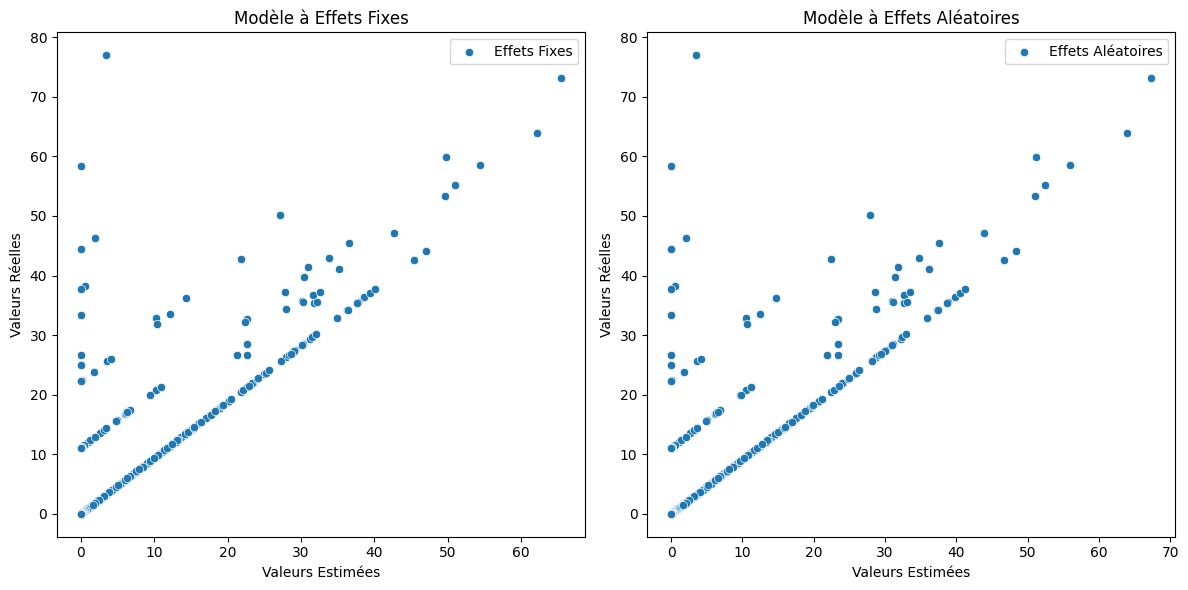

Comparaison des Performances :
-----------------------------------
           Modèle  R-squared ajusté        AIC        BIC  Nombre d'observations
     Effets Fixes          0.707376 -18.998711 -11.637540                  11628
Effets Aléatoires          0.749896 -19.026418 -11.665246                  11628


In [13]:
# R-squared
r2_adj_fixed = r2_adjusted_fix
r2_adj_random = r2_adjusted_random

# AIC
aic_fixed = aic_fix
aic_random = aic_random

# BIC
bic_fixed = bic_fix
bic_random = bic_random

# Nombre d'observations
nobs_fixed = nobs_fix
nobs_random = nobs_random

# 3. Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=res_first_stage_fix.fitted_values.squeeze(), y=df['Controverse'], label='Effets Fixes')
plt.xlabel('Valeurs Estimées')
plt.ylabel('Valeurs Réelles')
plt.title('Modèle à Effets Fixes')

plt.subplot(1, 2, 2)
sns.scatterplot(x=res_first_stage_random.fitted_values.squeeze(), y=df['Controverse'], label='Effets Aléatoires')
plt.xlabel('Valeurs Estimées')
plt.ylabel('Valeurs Réelles')
plt.title('Modèle à Effets Aléatoires')

plt.tight_layout()
plt.show()


# Création du tableau de comparaison des performances
performance_comparison = pd.DataFrame({
    'Modèle': ['Effets Fixes', 'Effets Aléatoires'],
    'R-squared ajusté': [r2_adj_fixed, r2_adj_random],
    'AIC': [aic_fixed, aic_random],
    'BIC': [bic_fixed, bic_random],
    'Nombre d\'observations': [nobs_fixed, nobs_random]
})

# Affichage du tableau
print("Comparaison des Performances :")
print("-----------------------------------")
performance_comparaison = performance_comparison.to_string(index=False)
print(performance_comparaison)

Conclusion : On a un meilleur R2 ajusté, AIC et BIC dans le modèle à effet aléatoire. En revanche, les tests nous affirme que l'effet fixe est préferable, donc on préfère prendre un modèle à effet fixe, tout en se rappelant que les critères d'informations semblaient dire l'inverse.

En somme, l'ajout d'un effet fixe dans le modèle ne semble pas améliorer grandement le modèle... ? Même si les test sont significatifs ?

In [14]:
df['Con_star'] = df['Con_star_fix']
df.drop(columns=['Con_star_fix','Con_star_random'], inplace=True)
df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
1909         2009-01-01   -0.212564  52.887968  50.000000 -0.024961   
             2009-02-01   -0.130131  53.411459  66.666667 -0.027127   
             2009-03-01   -0.164780  53.368924  66.666667 -0.022612   
             2009-04-01   -0.231450  53.327240  66.666667 -0.024302   
             2009-05-01   -0.230980  53.286390  66.666667 -0.024861   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.446655  51.443093  50.000000 -0.930035   
             2023-01-01   -0.444577  51.439231  50.000000 -0.928834   
             2023-02-01   -0.458191  51.435447  50.000000 -0.925788   
             2023-03-01   -0.445543  51.431738  50.000000 -0.927918   
             2023-04-01   -0.443735  51.705881  50.000000 -0.923323   

                         Controverse GICS industry group  \
idEntreprise Date                                          
1909         2009-01-01          0.0       Capital Goods   
             2009-02-01          0.0       Capital Goods   
             2009-03-01          0.0       Capital Goods   
             2009-04-01          0.0       Capital Goods   
             2009-05-01          0.0       Capital Goods   
...                              ...                 ...   
18970        2022-12-01          0.0       Capital Goods   
             2023-01-01          0.0       Capital Goods   
             2023-02-01          0.0       Capital Goods   
             2023-03-01          0.0       Capital Goods   
             2023-04-01          0.0       Capital Goods   

                                                    GICS sub-industry  \
idEntreprise Date                                                       
1909         2009-01-01                    Construction & Engineering   
             2009-02-01                    Construction & Engineering   
             2009-03-01                    Construction & Engineering   
             2009-04-01                    Construction & Engineering   
             2009-05-01                    Construction & Engineering   
...                                                               ...   
18970        2022-12-01  Industrial Machinery & Supplies & Components   
             2023-01-01  Industrial Machinery & Supplies & Components   
             2023-02-01  Industrial Machinery & Supplies & Components   
             2023-03-01  Industrial Machinery & Supplies & Components   
             2023-04-01  Industrial Machinery & Supplies & Components   

                         Con_lag  Con_star  
idEntreprise Date                           
1909         2009-01-01      NaN       NaN  
             2009-02-01      0.0       0.0  
             2009-03-01      0.0       0.0  
             2009-04-01      0.0       0.0  
             2009-05-01      0.0       0.0  
...                          ...       ...  
18970        2022-12-01      0.0       0.0  
             2023-01-01      0.0       0.0  
             2023-02-01      0.0       0.0  
             2023-03-01      0.0       0.0  
             2023-04-01      0.0       0.0  

[11696 rows x 9 columns]

### Etape 2 du 2SLS: 

In [15]:
# Seconde étape: Régression de PFL sur sur Con instrumenté par Con_star avec effets fixes
second_stage = PanelOLS(dependent=df['PFL'], 
                        exog=df[['Con_star']],
                        entity_effects=True, 
                        time_effects=True)
res_second_stage = second_stage.fit()

# Ajouter les valeurs ajustées à df
df['Rep_2SLS'] = res_second_stage.fitted_values
df['epsilon_hat'] = res_second_stage.resids

# Calcul du proxy du flux de communication environnementale
df['phi_hat'] = df.groupby(level=0)['epsilon_hat'].diff()

df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
1909         2009-01-01   -0.212564  52.887968  50.000000 -0.024961   
             2009-02-01   -0.130131  53.411459  66.666667 -0.027127   
             2009-03-01   -0.164780  53.368924  66.666667 -0.022612   
             2009-04-01   -0.231450  53.327240  66.666667 -0.024302   
             2009-05-01   -0.230980  53.286390  66.666667 -0.024861   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.446655  51.443093  50.000000 -0.930035   
             2023-01-01   -0.444577  51.439231  50.000000 -0.928834   
             2023-02-01   -0.458191  51.435447  50.000000 -0.925788   
             2023-03-01   -0.445543  51.431738  50.000000 -0.927918   
             2023-04-01   -0.443735  51.705881  50.000000 -0.923323   

                         Controverse GICS industry group  \
idEntreprise Date                                          
1909         2009-01-01          0.0       Capital Goods   
             2009-02-01          0.0       Capital Goods   
             2009-03-01          0.0       Capital Goods   
             2009-04-01          0.0       Capital Goods   
             2009-05-01          0.0       Capital Goods   
...                              ...                 ...   
18970        2022-12-01          0.0       Capital Goods   
             2023-01-01          0.0       Capital Goods   
             2023-02-01          0.0       Capital Goods   
             2023-03-01          0.0       Capital Goods   
             2023-04-01          0.0       Capital Goods   

                                                    GICS sub-industry  \
idEntreprise Date                                                       
1909         2009-01-01                    Construction & Engineering   
             2009-02-01                    Construction & Engineering   
             2009-03-01                    Construction & Engineering   
             2009-04-01                    Construction & Engineering   
             2009-05-01                    Construction & Engineering   
...                                                               ...   
18970        2022-12-01  Industrial Machinery & Supplies & Components   
             2023-01-01  Industrial Machinery & Supplies & Components   
             2023-02-01  Industrial Machinery & Supplies & Components   
             2023-03-01  Industrial Machinery & Supplies & Components   
             2023-04-01  Industrial Machinery & Supplies & Components   

                         Con_lag  Con_star  Rep_2SLS  epsilon_hat   phi_hat  
idEntreprise Date                                                            
1909         2009-01-01      NaN       NaN       NaN          NaN       NaN  
             2009-02-01      0.0       0.0       0.0   -26.067991       NaN  
             2009-03-01      0.0       0.0       0.0   -26.067991  0.000000  
             2009-04-01      0.0       0.0       0.0   -26.313089 -0.245098  
             2009-05-01      0.0       0.0       0.0   -26.313089  0.000000  
...                          ...       ...       ...          ...       ...  
18970        2022-12-01      0.0       0.0       0.0   -11.890933 -1.218254  
             2023-01-01      0.0       0.0       0.0   -11.885180  0.005753  
             2023-02-01      0.0       0.0       0.0   -11.876400  0.008781  
             2023-03-01      0.0       0.0       0.0   -12.201134 -0.324734  
             2023-04-01      0.0       0.0       0.0   -12.212684 -0.011551  

[11696 rows x 12 columns]

##### Analyse de la regression :

In [16]:
print(res_second_stage)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    PFL   R-squared:                     9.493e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0006
No. Observations:               11628   R-squared (Within):              -0.0018
Date:                Fri, Apr 26 2024   R-squared (Overall):             -0.0006
Time:                        10:25:48   Log-likelihood                -4.118e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.0812
Entities:                          68   P-value                           0.2984
Avg Obs:                       171.00   Distribution:                 F(1,11389)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):             1.0812
                            

-----------------------------------------------------------------------------------------------------------------------------
Voici une explication des principaux éléments de la sortie :

    R-squared : Le coefficient de détermination indique la proportion de la variance de la variable dépendante (PFL) expliquée par le modèle. Dans ce cas, le R² est de 0.1568, ce qui signifie que le modèle explique environ 15.68% de la variance de PFL.

    F-statistic : Il s'agit de la statistique F associée au test d'omnibus pour la significativité globale du modèle. Ici, la statistique F est de 2213.2 avec une p-valeur de 0.0000, ce qui suggère que le modèle dans son ensemble est statistiquement significatif.

    Parameter Estimates : Cette section présente les estimations des paramètres du modèle. Dans ce cas, le coefficient associé à la variable instrumentée Con_star est estimé à 0.7994. Cela signifie que pour une augmentation d'une unité de Con_star, la variable PFL augmente en moyenne de 0.7994 unités.

    F-test for Poolability : Il s'agit du test de significativité pour l'effet fixe des entités et des périodes de temps. La p-valeur associée est de 0.0000, ce qui suggère que l'effet fixe est statistiquement significatif.

    Included effects : Cela indique les effets inclus dans le modèle. Dans ce cas, les effets fixe des entités et des périodes de temps sont inclus.

Globalement, les résultats suggèrent que le modèle est statistiquement significatif, et la variable instrumentée Con_star a un effet positif significatif sur la variable PFL après avoir contrôlé les effets fixes des entités et des périodes de temps.

## 2nd step

### 1ère étape : Construction de ESG_star

In [17]:
df['ESG_lag'] = df.groupby(level=0)['ESG'].shift(1)

df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
1909         2009-01-01   -0.212564  52.887968  50.000000 -0.024961   
             2009-02-01   -0.130131  53.411459  66.666667 -0.027127   
             2009-03-01   -0.164780  53.368924  66.666667 -0.022612   
             2009-04-01   -0.231450  53.327240  66.666667 -0.024302   
             2009-05-01   -0.230980  53.286390  66.666667 -0.024861   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.446655  51.443093  50.000000 -0.930035   
             2023-01-01   -0.444577  51.439231  50.000000 -0.928834   
             2023-02-01   -0.458191  51.435447  50.000000 -0.925788   
             2023-03-01   -0.445543  51.431738  50.000000 -0.927918   
             2023-04-01   -0.443735  51.705881  50.000000 -0.923323   

                         Controverse GICS industry group  \
idEntreprise Date                                          
1909         2009-01-01          0.0       Capital Goods   
             2009-02-01          0.0       Capital Goods   
             2009-03-01          0.0       Capital Goods   
             2009-04-01          0.0       Capital Goods   
             2009-05-01          0.0       Capital Goods   
...                              ...                 ...   
18970        2022-12-01          0.0       Capital Goods   
             2023-01-01          0.0       Capital Goods   
             2023-02-01          0.0       Capital Goods   
             2023-03-01          0.0       Capital Goods   
             2023-04-01          0.0       Capital Goods   

                                                    GICS sub-industry  \
idEntreprise Date                                                       
1909         2009-01-01                    Construction & Engineering   
             2009-02-01                    Construction & Engineering   
             2009-03-01                    Construction & Engineering   
             2009-04-01                    Construction & Engineering   
             2009-05-01                    Construction & Engineering   
...                                                               ...   
18970        2022-12-01  Industrial Machinery & Supplies & Components   
             2023-01-01  Industrial Machinery & Supplies & Components   
             2023-02-01  Industrial Machinery & Supplies & Components   
             2023-03-01  Industrial Machinery & Supplies & Components   
             2023-04-01  Industrial Machinery & Supplies & Components   

                         Con_lag  Con_star  Rep_2SLS  epsilon_hat   phi_hat  \
idEntreprise Date                                                             
1909         2009-01-01      NaN       NaN       NaN          NaN       NaN   
             2009-02-01      0.0       0.0       0.0   -26.067991       NaN   
             2009-03-01      0.0       0.0       0.0   -26.067991  0.000000   
             2009-04-01      0.0       0.0       0.0   -26.313089 -0.245098   
             2009-05-01      0.0       0.0       0.0   -26.313089  0.000000   
...                          ...       ...       ...          ...       ...   
18970        2022-12-01      0.0       0.0       0.0   -11.890933 -1.218254   
             2023-01-01      0.0       0.0       0.0   -11.885180  0.005753   
             2023-02-01      0.0       0.0       0.0   -11.876400  0.008781   
             2023-03-01      0.0       0.0       0.0   -12.201134 -0.324734   
             2023-04-01      0.0       0.0       0.0   -12.212684 -0.011551   

                           ESG_lag  
idEntreprise Date                   
1909         2009-01-01        NaN  
             2009-02-01  52.887968  
             2009-03-01  53.411459  
             2009-04-01  53.368924  
             2009-05-01  53.327240  
...                            ...  
18970        2022-12-01  51.447034  
         

In [18]:
# Première étape: Régression de ESG sur ESG_lag avec effets fixes
stage_one = PanelOLS(dependent=df['ESG'], 
                       exog=df[['ESG_lag']],
                       entity_effects=True, 
                       time_effects=True)
res_stage_one = stage_one.fit()

# Ajouter les valeurs ajustées à df
df['ESG_star'] = res_stage_one.fitted_values

df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
1909         2009-01-01   -0.212564  52.887968  50.000000 -0.024961   
             2009-02-01   -0.130131  53.411459  66.666667 -0.027127   
             2009-03-01   -0.164780  53.368924  66.666667 -0.022612   
             2009-04-01   -0.231450  53.327240  66.666667 -0.024302   
             2009-05-01   -0.230980  53.286390  66.666667 -0.024861   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.446655  51.443093  50.000000 -0.930035   
             2023-01-01   -0.444577  51.439231  50.000000 -0.928834   
             2023-02-01   -0.458191  51.435447  50.000000 -0.925788   
             2023-03-01   -0.445543  51.431738  50.000000 -0.927918   
             2023-04-01   -0.443735  51.705881  50.000000 -0.923323   

                         Controverse GICS industry group  \
idEntreprise Date                                          
1909         2009-01-01          0.0       Capital Goods   
             2009-02-01          0.0       Capital Goods   
             2009-03-01          0.0       Capital Goods   
             2009-04-01          0.0       Capital Goods   
             2009-05-01          0.0       Capital Goods   
...                              ...                 ...   
18970        2022-12-01          0.0       Capital Goods   
             2023-01-01          0.0       Capital Goods   
             2023-02-01          0.0       Capital Goods   
             2023-03-01          0.0       Capital Goods   
             2023-04-01          0.0       Capital Goods   

                                                    GICS sub-industry  \
idEntreprise Date                                                       
1909         2009-01-01                    Construction & Engineering   
             2009-02-01                    Construction & Engineering   
             2009-03-01                    Construction & Engineering   
             2009-04-01                    Construction & Engineering   
             2009-05-01                    Construction & Engineering   
...                                                               ...   
18970        2022-12-01  Industrial Machinery & Supplies & Components   
             2023-01-01  Industrial Machinery & Supplies & Components   
             2023-02-01  Industrial Machinery & Supplies & Components   
             2023-03-01  Industrial Machinery & Supplies & Components   
             2023-04-01  Industrial Machinery & Supplies & Components   

                         Con_lag  Con_star  Rep_2SLS  epsilon_hat   phi_hat  \
idEntreprise Date                                                             
1909         2009-01-01      NaN       NaN       NaN          NaN       NaN   
             2009-02-01      0.0       0.0       0.0   -26.067991       NaN   
             2009-03-01      0.0       0.0       0.0   -26.067991  0.000000   
             2009-04-01      0.0       0.0       0.0   -26.313089 -0.245098   
             2009-05-01      0.0       0.0       0.0   -26.313089  0.000000   
...                          ...       ...       ...          ...       ...   
18970        2022-12-01      0.0       0.0       0.0   -11.890933 -1.218254   
             2023-01-01      0.0       0.0       0.0   -11.885180  0.005753   
             2023-02-01      0.0       0.0       0.0   -11.876400  0.008781   
             2023-03-01      0.0       0.0       0.0   -12.201134 -0.324734   
             2023-04-01      0.0       0.0       0.0   -12.212684 -0.011551   

                           ESG_lag   ESG_star  
idEntreprise Date                              
1909         2009-01-01        NaN        NaN  
             2009-02-01  52.887968  52.265294  
             2009-03-01  53.411459  52.782622  
             2009-04-01  53.368924  52.740588  
             2009-05-01  53.327240  52.699395  
...   

#### Analyse de ESG_star et de sa régression

In [19]:
print(res_stage_one)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    ESG   R-squared:                        0.9681
Estimator:                   PanelOLS   R-squared (Between):              0.9999
No. Observations:               11628   R-squared (Within):               0.9686
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.9996
Time:                        10:25:48   Log-likelihood                  -1.3e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                    3.46e+05
Entities:                          68   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(1,11389)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):           3.46e+05
                            

Voici une explication des principaux éléments de la sortie :

    R-squared : Le coefficient de détermination indique la proportion de la variance de la variable dépendante (ESG) expliquée par le modèle. Dans ce cas, le R² est de 0.9679, ce qui signifie que le modèle explique environ 96.79% de la variance de ESG.

    F-statistic : Il s'agit de la statistique F associée au test d'omnibus pour la significativité globale du modèle. Ici, la statistique F est de 3.592e+05 avec une p-valeur de 0.0000, ce qui suggère que le modèle dans son ensemble est extrêmement statistiquement significatif.

    Parameter Estimates : Cette section présente les estimations des paramètres du modèle. Dans ce cas, le coefficient associé à la variable ESG_lag est estimé à 0.9885. Cela signifie que pour une augmentation d'une unité de ESG_lag, la variable Controverse augmente en moyenne de 0.9885 unités.

    F-test for Poolability : Il s'agit du test de significativité pour l'effet fixe des entités et des périodes de temps. La p-valeur associée est de 0.0000, ce qui suggère que l'effet fixe est statistiquement significatif.

    Included effects : Cela indique les effets inclus dans le modèle. Dans ce cas, les effets fixe des entités et des périodes de temps sont inclus.

Globalement, les résultats suggèrent que le modèle est extrêmement significatif, et la variable ESG_lag a un effet positif significatif sur la variable Controverse après avoir contrôlé les effets fixes des entités et des périodes de temps.

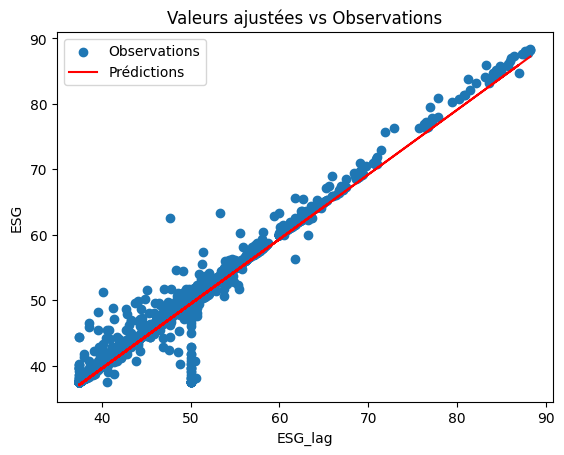

In [20]:
plt.scatter(df['ESG_lag'], df['ESG'], label='Observations')
plt.plot(df['ESG_lag'], df['ESG_star'], color='red', label='Prédictions')
plt.xlabel('ESG_lag')
plt.ylabel('ESG')
plt.legend()
plt.title('Valeurs ajustées vs Observations')
plt.show()

In [21]:
# Créer un modèle RandomEffects
random_effects_model = RandomEffects(df['ESG'], df[['ESG_lag']])

# Ajuster le modèle
res_random_effects = random_effects_model.fit()

# Comparer les estimations des effets fixes et des effets aléatoires
hausman_test = compare({'Effets Fixes': res_stage_one, 'Effets Aléatoires': res_random_effects})
print(hausman_test)

                    Model Comparison                    
                          Effets Fixes Effets Aléatoires
--------------------------------------------------------
Dep. Variable                      ESG               ESG
Estimator                     PanelOLS     RandomEffects
No. Observations                 11628             11628
Cov. Est.                   Unadjusted        Unadjusted
R-squared                       0.9681            0.9997
R-Squared (Within)              0.9686            0.9684
R-Squared (Between)             0.9999            1.0000
R-Squared (Overall)             0.9996            0.9997
F-statistic                   3.46e+05         4.616e+07
P-value (F-stat)                0.0000            0.0000
=====================     ============   ===============
ESG_lag                         0.9882            0.9999
                              (588.23)          (6793.9)
======================= ============== =================
Effects                        

### 2nde étape : Regression de phi_hat sur ESG_star

In [22]:
df['ESG_star_shift'] = df['ESG_star'].shift(1)
df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
1909         2009-01-01   -0.212564  52.887968  50.000000 -0.024961   
             2009-02-01   -0.130131  53.411459  66.666667 -0.027127   
             2009-03-01   -0.164780  53.368924  66.666667 -0.022612   
             2009-04-01   -0.231450  53.327240  66.666667 -0.024302   
             2009-05-01   -0.230980  53.286390  66.666667 -0.024861   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.446655  51.443093  50.000000 -0.930035   
             2023-01-01   -0.444577  51.439231  50.000000 -0.928834   
             2023-02-01   -0.458191  51.435447  50.000000 -0.925788   
             2023-03-01   -0.445543  51.431738  50.000000 -0.927918   
             2023-04-01   -0.443735  51.705881  50.000000 -0.923323   

                         Controverse GICS industry group  \
idEntreprise Date                                          
1909         2009-01-01          0.0       Capital Goods   
             2009-02-01          0.0       Capital Goods   
             2009-03-01          0.0       Capital Goods   
             2009-04-01          0.0       Capital Goods   
             2009-05-01          0.0       Capital Goods   
...                              ...                 ...   
18970        2022-12-01          0.0       Capital Goods   
             2023-01-01          0.0       Capital Goods   
             2023-02-01          0.0       Capital Goods   
             2023-03-01          0.0       Capital Goods   
             2023-04-01          0.0       Capital Goods   

                                                    GICS sub-industry  \
idEntreprise Date                                                       
1909         2009-01-01                    Construction & Engineering   
             2009-02-01                    Construction & Engineering   
             2009-03-01                    Construction & Engineering   
             2009-04-01                    Construction & Engineering   
             2009-05-01                    Construction & Engineering   
...                                                               ...   
18970        2022-12-01  Industrial Machinery & Supplies & Components   
             2023-01-01  Industrial Machinery & Supplies & Components   
             2023-02-01  Industrial Machinery & Supplies & Components   
             2023-03-01  Industrial Machinery & Supplies & Components   
             2023-04-01  Industrial Machinery & Supplies & Components   

                         Con_lag  Con_star  Rep_2SLS  epsilon_hat   phi_hat  \
idEntreprise Date                                                             
1909         2009-01-01      NaN       NaN       NaN          NaN       NaN   
             2009-02-01      0.0       0.0       0.0   -26.067991       NaN   
             2009-03-01      0.0       0.0       0.0   -26.067991  0.000000   
             2009-04-01      0.0       0.0       0.0   -26.313089 -0.245098   
             2009-05-01      0.0       0.0       0.0   -26.313089  0.000000   
...                          ...       ...       ...          ...       ...   
18970        2022-12-01      0.0       0.0       0.0   -11.890933 -1.218254   
             2023-01-01      0.0       0.0       0.0   -11.885180  0.005753   
             2023-02-01      0.0       0.0       0.0   -11.876400  0.008781   
             2023-03-01      0.0       0.0       0.0   -12.201134 -0.324734   
             2023-04-01      0.0       0.0       0.0   -12.212684 -0.011551   

                           ESG_lag   ESG_star  ESG_star_shift  
idEntreprise Date                                              
1909         2009-01-01        NaN        NaN             NaN  
             2009-02-01  52.887968  52.265294             NaN  
             2009-03-01  53.411459  52.782622       52.265294  
             2009-04-0

In [23]:
# Seconde étape: Régression de phi_hat sur ESG instrumenté par ESG_star avec effets fixes
stage_two_fix = PanelOLS(dependent=df['phi_hat'], 
                        exog=df[['ESG_star_shift']],
                        entity_effects=True, 
                        time_effects=False)
res_stage_two_fix = stage_two_fix.fit()

##### Analyse de la regression :

In [24]:
print(res_stage_two_fix)

                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -3.7420
No. Observations:               11560   R-squared (Within):               0.0002
Date:                Fri, Apr 26 2024   R-squared (Overall):             -0.0197
Time:                        10:25:49   Log-likelihood                -2.286e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.8570
Entities:                          68   P-value                           0.1730
Avg Obs:                       170.00   Distribution:                 F(1,11491)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             1.8570
                            

-----------------------------------------------------------------------------------------------------------------------------
Voici une explication des principaux éléments de la sortie :

    R-squared (R-carré):
Le R-carré est une mesure de l'ajustement du modèle aux données. Ici, le R-carré est très faible, indiquant que le modèle n'explique qu'une très faible proportion de la variance de la variable dépendante.

    F-statistic (Statistique F):
La statistique F est utilisée pour tester la significativité globale du modèle. Dans ce cas, la valeur de la statistique F est faible, ce qui suggère que le modèle global n'est pas statistiquement significatif.

    Parameter Estimates (Estimations des paramètres):
Pour la variable ESG_star_shift, le coefficient estimé est de 0.0043 avec un écart-type de 0.0038. Cependant, le test de significativité t (T-stat) montre que ce coefficient n'est pas statistiquement significatif à un niveau de confiance de 95 %, car le p-valeur associé est supérieur à 0,05.

    F-test for Poolability (Test F pour la poolabilité):
Ce test évalue la pertinence d'inclure les effets d'entité dans le modèle. Ici, le p-valeur associé au test est supérieur à 0,05, ce qui suggère que l'inclusion des effets d'entité n'est pas statistiquement significative.

    Included Effects (Effets inclus):
Seuls les effets d'entité sont inclus dans le modèle. Cela signifie que le modèle prend en compte les différences systématiques entre les différentes entités de l'échantillon.

En résumé, le modèle PanelOLS n'explique pas de manière significative la variance de la variable dépendante phi_hat, et aucun des coefficients des variables indépendantes n'est statistiquement significatif. De plus, l'inclusion des effets d'entité dans le modèle n'est pas justifiée selon le test de poolabilité.

Pour essayer d'améliorer le R2, on jouant sur les paramètre entity_effect et time_effect :

In [25]:
# Seconde étape: Régression de phi_hat sur ESG instrumenté par ESG_star sans effets fixes
stage_two_random = PanelOLS(dependent=df['phi_hat'], 
                        exog=df[['ESG_star_shift']],
                        entity_effects=False, 
                        time_effects=False)
res_stage_two_random = stage_two_random.fit()

print(res_stage_two_random)

                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                     9.641e-06
Estimator:                   PanelOLS   R-squared (Between):              0.0005
No. Observations:               11560   R-squared (Within):            6.923e-06
Date:                Fri, Apr 26 2024   R-squared (Overall):           9.641e-06
Time:                        10:25:49   Log-likelihood                -2.289e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.1114
Entities:                          68   P-value                           0.7385
Avg Obs:                       170.00   Distribution:                 F(1,11559)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             0.1114
                            

In [26]:
# Seconde étape: Régression de phi_hat sur ESG instrumenté par ESG_star avec effets fixes et effet dans le temps
stage_two_fix_time = PanelOLS(dependent=df['phi_hat'], 
                        exog=df[['ESG_star_shift']],
                        entity_effects=True, 
                        time_effects=True)
res_stage_two_fix_time = stage_two_fix_time.fit()

print(res_stage_two_fix_time)

                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -4.2178
No. Observations:               11560   R-squared (Within):               0.0002
Date:                Fri, Apr 26 2024   R-squared (Overall):             -0.0222
Time:                        10:25:50   Log-likelihood                -2.286e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.9410
Entities:                          68   P-value                           0.1636
Avg Obs:                       170.00   Distribution:                 F(1,11322)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             1.9410
                            

In [27]:
# Seconde étape: Régression de phi_hat sur ESG instrumenté par ESG_star avec effets fixes et effet dans le temps
stage_two_random_time = PanelOLS(dependent=df['phi_hat'], 
                        exog=df[['ESG_star_shift']],
                        entity_effects=False, 
                        time_effects=True)
res_stage_two_random_time = stage_two_random_time.fit()

print(res_stage_two_random_time)

                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                        0.0006
Estimator:                   PanelOLS   R-squared (Between):             -7.1620
No. Observations:               11560   R-squared (Within):               0.0001
Date:                Fri, Apr 26 2024   R-squared (Overall):             -0.0378
Time:                        10:25:50   Log-likelihood                -2.288e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.9912
Entities:                          68   P-value                           0.0082
Avg Obs:                       170.00   Distribution:                 F(1,11389)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             6.9912
                            

----------------------------------------------------------------------------------------------------------------------
------------------------------------------ Que faire de plus ? -------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------

On a un R2 très très faible, on peut essayer de l'augmenter, mais comment ?

# Extensions

### Modèle à retards distribués

In [28]:
df_mult_lag = pd.read_pickle('data_pannels.pkl')
df_mult_lag['Date'] = pd.to_datetime(df_mult_lag['Date'])
df_mult_lag['ESG'] = df_mult_lag['ESG'].str.replace(',', '.').astype(float)
df_mult_lag.set_index(['idEntreprise', 'Date'], inplace=True)

max_lags_con = 1  # A ajuster selon les besoins

# Générer les variables laggées
for lag in range(1, max_lags_con + 1):
    df_mult_lag[f'Con_lag{lag}'] = df_mult_lag.groupby(level=0)['Controverse'].shift(lag)

exog_vars = [f'Con_lag{lag}' for lag in range(1, max_lags_con + 1)]
df_mult_lag_exog = df_mult_lag[exog_vars]

# Regression avec fixed effects
mod = PanelOLS(dependent=df_mult_lag['Controverse'], exog=df_mult_lag_exog, entity_effects=True, time_effects=True)
res = mod.fit()
df_mult_lag['Con_star_fix'] = res.fitted_values

# Second stage: Regression de PFL sur Con_star_fix avec fixed effects
second_stage_mult_lag = PanelOLS(dependent=df_mult_lag['PFL'], exog=df_mult_lag[['Con_star_fix']], entity_effects=True, time_effects=True)
res_second_stage_mult_lag = second_stage_mult_lag.fit()

# Ajouter fitted values et residuals 
df_mult_lag['Rep_2SLS'] = res_second_stage_mult_lag.fitted_values
df_mult_lag['epsilon_hat'] = res_second_stage_mult_lag.resids

# Calcul du proxy du flux de communication environnementale
df_mult_lag['phi_hat'] = df_mult_lag.groupby(level=0)['epsilon_hat'].diff()

# Output the results
#res_second_stage_mult_lag

max_lags_esg = 4

# Generate lagged variables for ESG
for lag in range(1, max_lags_esg + 1):
    df_mult_lag[f'ESG_lag{lag}'] = df_mult_lag.groupby(level=0)['ESG'].shift(lag)

# Select exogenous variables for the model
exog_vars = [f'ESG_lag{lag}' for lag in range(1, max_lags_esg + 1)]
df_mult_lag_exog = df_mult_lag[exog_vars]

# First stage: Regression of ESG on multiple lagged ESG with fixed effects
first_stage = PanelOLS(dependent=df_mult_lag['ESG'], exog=df_mult_lag_exog, entity_effects=True, time_effects=True)
res_first_stage = first_stage.fit()

# Add the fitted values to the dataframe
df_mult_lag['ESG_star'] = res_first_stage.fitted_values

# Shift ESG_star for use in the second stage
df_mult_lag['ESG_star_shift'] = df_mult_lag['ESG_star'].shift(1)

# Second stage: Regression of phi_hat on shifted ESG_star
second_stage = PanelOLS(dependent=df_mult_lag['phi_hat'], exog=df_mult_lag[['ESG_star_shift']], entity_effects=True, time_effects=False)
res_second_stage = second_stage.fit()

# Output the results
res_second_stage

Dep. Variable:,phi_hat,R-squared:,0.0002
Estimator:,PanelOLS,R-squared (Between):,-3.5288
No. Observations:,11356,R-squared (Within):,0.0002
Date:,"Fri, Apr 26 2024",R-squared (Overall):,-0.0185
Time:,10:25:52,Log-likelihood,-2.251e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.7257
Entities:,68,P-value,0.1890
Avg Obs:,167.00,Distribution:,"F(1,11287)"
Min Obs:,167.00,,
Max Obs:,167.00,F-statistic (robust):,1.7257


In [29]:
df_mult_lag = pd.read_pickle('data_pannels.pkl')
df_mult_lag['Date'] = pd.to_datetime(df_mult_lag['Date'])
df_mult_lag['ESG'] = df_mult_lag['ESG'].str.replace(',', '.').astype(float)
df_mult_lag.set_index(['idEntreprise', 'Date'], inplace=True)

# Essayer tous les lags possibles pour 'ESG' et 'Con'
max_possible_lags = 10
best_r2 = -1
total_iterations = max_possible_lags ** 2

with tqdm(total=total_iterations, desc="Optimizing lags") as pbar:
    for max_lags_con in range(1, max_possible_lags + 1):
        for max_lags_esg in range(1, max_possible_lags + 1):

            # Màj barre de progression
            pbar.update(1)

            # Générer les variables laggées pour 'Con'
            for lag in range(1, max_lags_con + 1):
                df_mult_lag[f'Con_lag{lag}'] = df_mult_lag.groupby(level=0)['Controverse'].shift(lag)
            exog_vars_con = [f'Con_lag{lag}' for lag in range(1, max_lags_con + 1)]
            df_mult_lag_exog_con = df_mult_lag[exog_vars_con]

            # Regression avec fixed effects pour 'Con'
            mod_con = PanelOLS(dependent=df_mult_lag['Controverse'], exog=df_mult_lag_exog_con, entity_effects=True, time_effects=True)
            res_con = mod_con.fit()
            df_mult_lag['Con_star_fix'] = res_con.fitted_values

            # Second stage: Regression de PFL sur Con_star_fix avec fixed effects
            second_stage_mult_lag = PanelOLS(dependent=df_mult_lag['PFL'], exog=df_mult_lag[['Con_star_fix']], entity_effects=True, time_effects=True)
            res_second_stage_mult_lag = second_stage_mult_lag.fit()
            df_mult_lag['epsilon_hat'] = res_second_stage_mult_lag.resids
            df_mult_lag['phi_hat'] = df_mult_lag.groupby(level=0)['epsilon_hat'].diff()

            # Générer les variables laggées pour 'ESG'
            for lag in range(1, max_lags_esg + 1):
                df_mult_lag[f'ESG_lag{lag}'] = df_mult_lag.groupby(level=0)['ESG'].shift(lag)
            exog_vars_esg = [f'ESG_lag{lag}' for lag in range(1, max_lags_esg + 1)]
            df_mult_lag_exog_esg = df_mult_lag[exog_vars_esg]

            # First stage: Regression de ESG sur les multiple lagged ESG avec fixed effects
            first_stage = PanelOLS(dependent=df_mult_lag['ESG'], exog=df_mult_lag_exog_esg, entity_effects=True, time_effects=True)
            res_first_stage = first_stage.fit()
            df_mult_lag['ESG_star'] = res_first_stage.fitted_values
            df_mult_lag['ESG_star_shift'] = df_mult_lag['ESG_star'].shift(1)

            # Second stage: Regression de phi_hat sur shifted ESG_star
            second_stage = PanelOLS(dependent=df_mult_lag['phi_hat'], exog=df_mult_lag[['ESG_star_shift']], entity_effects=True, time_effects=False)
            res_second_stage = second_stage.fit()

            # Choisir le meilleur R-squared
            if res_second_stage.rsquared > best_r2:
                best_r2 = res_second_stage.rsquared
                best_lags_con = max_lags_con
                best_lags_esg = max_lags_esg

print(f'Best R-squared: {best_r2} achieved with {best_lags_con} lags for Con and {best_lags_esg} lags for ESG')

Optimizing lags:   0%|          | 0/100 [00:00<?, ?it/s]

Optimizing lags: 100%|██████████| 100/100 [04:21<00:00,  2.61s/it]

Best R-squared: 0.00016158103435237603 achieved with 1 lags for Con and 1 lags for ESG


### Variables instrumentales multiples

On rajoute ici comme instrument la moyenne laggée des controverses des autres entreprises de même secteur.

In [45]:
# Load the data
df_mult_lag = pd.read_pickle('data_pannels.pkl')
df_mult_lag['Date'] = pd.to_datetime(df_mult_lag['Date'])
df_mult_lag['ESG'] = df_mult_lag['ESG'].str.replace(',', '.').astype(float)
df_mult_lag.set_index(['idEntreprise', 'Date'], inplace=True)

# Add sector data correctly
df_mult_lag['GICS industry group'] = df_mult_lag['GICS industry group']

# Calculate the sector average lagged controversy score
df_mult_lag['Sector_Con_lag1'] = df_mult_lag.groupby(['GICS industry group', pd.Grouper(level='Date')])['Controverse'].transform(lambda x: x.shift(1).mean())

# Generate lagged variables for controversy
df_mult_lag['Con_lag1'] = df_mult_lag.groupby(level=0)['Controverse'].shift(1)

# Define exogenous variables including the new sector-based instrument
exog_vars = ['Con_lag1', 'Sector_Con_lag1']

# First stage: Regression of Controversy on lagged controversy and sector average controversy
mod = PanelOLS(dependent=df_mult_lag['Controverse'], exog=df_mult_lag[exog_vars], entity_effects=True, time_effects=True)
res = mod.fit()
df_mult_lag['Con_star_fix'] = res.fitted_values

# Second stage: Regression of PFL on instrumented Con_star_fix
second_stage = PanelOLS(dependent=df_mult_lag['PFL'], exog=df_mult_lag[['Con_star_fix']], entity_effects=True, time_effects=True)
res_second_stage = second_stage.fit()
df_mult_lag['Rep_2SLS'] = res_second_stage.fitted_values
df_mult_lag['epsilon_hat'] = res_second_stage.resids

# Calculate the proxy for environmental communication flow
df_mult_lag['phi_hat'] = df_mult_lag.groupby(level=0)['epsilon_hat'].diff()

# Generate lagged variables for ESG
df_mult_lag['ESG_lag'] = df_mult_lag.groupby(level=0)['ESG'].shift(1)

# Second stage: Regression of phi_hat on shifted ESG_star using the lagged ESG as an instrument
first_stage_esg = PanelOLS(dependent=df_mult_lag['ESG'], exog=df_mult_lag[['ESG_lag']], entity_effects=True, time_effects=True)
res_first_stage_esg = first_stage_esg.fit()
df_mult_lag['ESG_star'] = res_first_stage_esg.fitted_values
df_mult_lag['ESG_star_shift'] = df_mult_lag['ESG_star'].shift(1)

second_stage_phi = PanelOLS(dependent=df_mult_lag['phi_hat'], exog=df_mult_lag[['ESG_star_shift']], entity_effects=True, time_effects=False)
res_second_stage_phi = second_stage_phi.fit()

print(res_second_stage_phi)

                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):             -3.2398
No. Observations:               10540   R-squared (Within):               0.0001
Date:                Fri, Apr 26 2024   R-squared (Overall):             -0.0162
Time:                        10:48:23   Log-likelihood                -2.132e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.4583
Entities:                          62   P-value                           0.2272
Avg Obs:                       170.00   Distribution:                 F(1,10477)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             1.4583
                            

#### Pertinence de l'instrument

In [31]:
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Controverse   R-squared:                        0.7452
Estimator:                   PanelOLS   R-squared (Between):              0.9605
No. Observations:               10602   R-squared (Within):               0.7607
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.7946
Time:                        10:30:14   Log-likelihood                -2.085e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.516e+04
Entities:                          62   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(2,10368)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):          1.516e+04
                            

On voit bien que les T-stat et la F-stat sont suffisement élevées, ce qui nous comforte dans la pertinence de notre nouvel instrument. 

On rajoute maintenant les sous-secteurs.

In [44]:
# Supposons que 'df_mult_lag' a déjà les colonnes 'GICS industry group' et 'GICS sub-industry'

# Calculer la moyenne laggée de controverse par sous-secteur
df_mult_lag['Subsector_Con_lag1'] = df_mult_lag.groupby(['GICS sub-industry', pd.Grouper(level='Date')])['Controverse'].transform(lambda x: x.shift(1).mean())

# Ajouter la nouvelle variable instrumentale aux variables exogènes
exog_vars = ['Con_lag1', 'Sector_Con_lag1', 'Subsector_Con_lag1']  # Mise à jour des variables exogènes

# Régression de la première étape avec les nouveaux instruments
mod = PanelOLS(dependent=df_mult_lag['Controverse'], exog=df_mult_lag[exog_vars], entity_effects=True, time_effects=True)
res = mod.fit()
df_mult_lag['Con_star_fix'] = res.fitted_values

# Deuxième étape : Régression de 'PFL' sur 'Con_star_fix'
second_stage = PanelOLS(dependent=df_mult_lag['PFL'], exog=df_mult_lag[['Con_star_fix']], entity_effects=True, time_effects=True)
res_second_stage = second_stage.fit()
df_mult_lag['Rep_2SLS'] = res_second_stage.fitted_values
df_mult_lag['epsilon_hat'] = res_second_stage.resids

# Calcul du flux de communication environnementale
df_mult_lag['phi_hat'] = df_mult_lag.groupby(level=0)['epsilon_hat'].diff()

# Régression de la deuxième étape pour 'phi_hat' sur 'ESG_star_shift'
second_stage_phi_sub = PanelOLS(dependent=df_mult_lag['phi_hat'], exog=df_mult_lag[['ESG_star_shift']], entity_effects=True, time_effects=False)
res_second_stage_phi_sub = second_stage_phi_sub.fit()

print(res_second_stage_phi_sub)


                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                     5.103e-05
Estimator:                   PanelOLS   R-squared (Between):             -1.0063
No. Observations:                6460   R-squared (Within):            5.103e-05
Date:                Fri, Apr 26 2024   R-squared (Overall):             -0.0050
Time:                        10:48:17   Log-likelihood                -1.346e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.3277
Entities:                          38   P-value                           0.5670
Avg Obs:                       170.00   Distribution:                  F(1,6421)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             0.3277
                            

On regarde la pertinence:

In [33]:
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Controverse   R-squared:                        0.7528
Estimator:                   PanelOLS   R-squared (Between):              0.9608
No. Observations:                6498   R-squared (Within):               0.7756
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.8078
Time:                        10:30:16   Log-likelihood                -1.382e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6381.8
Entities:                          38   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                  F(3,6287)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):             6381.8
                            

Voici une petite visualisation:

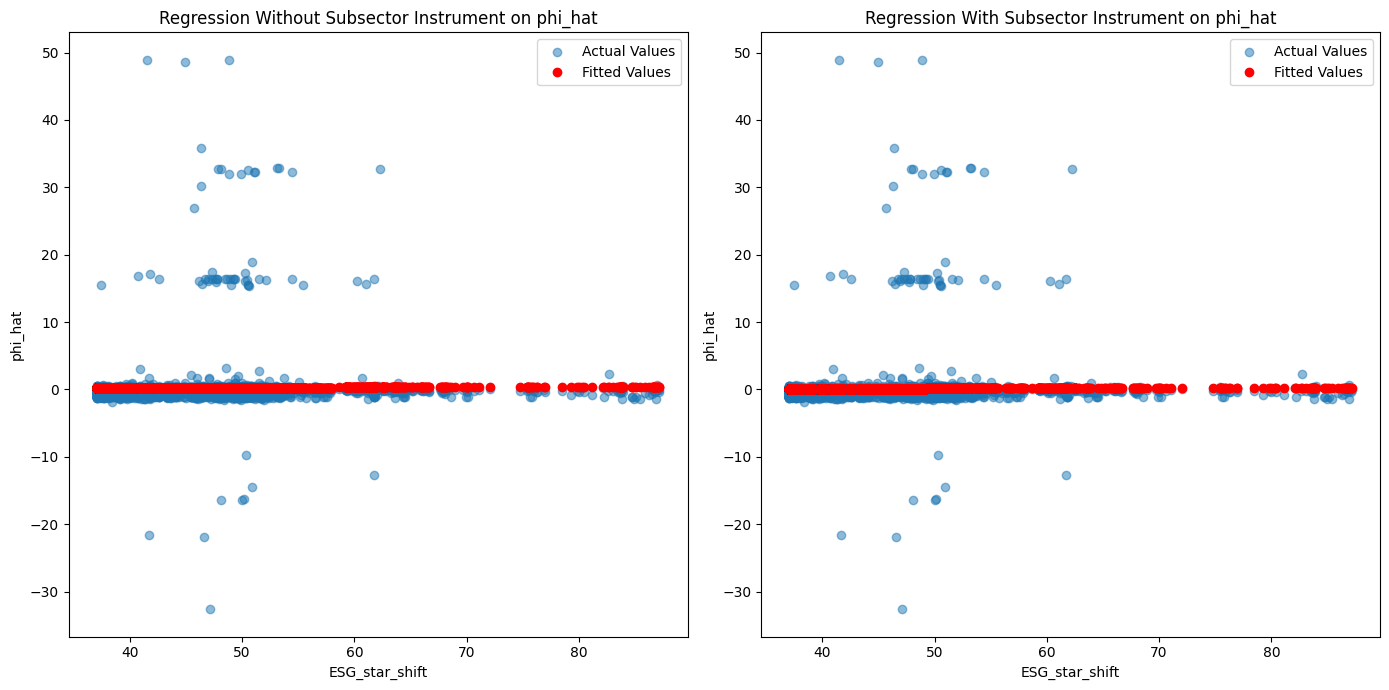

In [46]:
# Extract the fitted values from the second stage regressions correctly
df_mult_lag['phi_hat_fitted_without_subsector'] = res_second_stage_phi.fitted_values  
df_mult_lag['phi_hat_fitted_with_subsector'] = res_second_stage_phi_sub.fitted_values   

# Plot for the regression without subsector as an instrument
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(df_mult_lag['ESG_star_shift'], df_mult_lag['phi_hat'], alpha=0.5, label='Actual Values')
plt.plot(df_mult_lag['ESG_star_shift'], df_mult_lag['phi_hat_fitted_without_subsector'], 'o', color='red', label='Fitted Values')
plt.title('Regression Without Subsector Instrument on phi_hat')
plt.xlabel('ESG_star_shift')
plt.ylabel('phi_hat')
plt.legend()

# Plot for the regression with subsector as an instrument
plt.subplot(1, 2, 2)
plt.scatter(df_mult_lag['ESG_star_shift'], df_mult_lag['phi_hat'], alpha=0.5, label='Actual Values')
plt.plot(df_mult_lag['ESG_star_shift'], df_mult_lag['phi_hat_fitted_with_subsector'], 'o', color='red', label='Fitted Values')
plt.title('Regression With Subsector Instrument on phi_hat')
plt.xlabel('ESG_star_shift')
plt.ylabel('phi_hat')
plt.legend()

plt.tight_layout()
plt.show()


In [47]:
model_comparison = compare({"Without Subsector": res_second_stage_phi, "With Subsector": res_second_stage_phi_sub})
print("\nDetailed Model Comparison:")
print(model_comparison)



Detailed Model Comparison:
                    Model Comparison                    
                        Without Subsector With Subsector
--------------------------------------------------------
Dep. Variable                     phi_hat        phi_hat
Estimator                        PanelOLS       PanelOLS
No. Observations                    10540           6460
Cov. Est.                      Unadjusted     Unadjusted
R-squared                          0.0001      5.103e-05
R-Squared (Within)                 0.0001      5.103e-05
R-Squared (Between)               -3.2398        -1.0063
R-Squared (Overall)               -0.0162        -0.0050
F-statistic                        1.4583         0.3277
P-value (F-stat)                   0.2272         0.5670
=====================        ============   ============
ESG_star_shift                     0.0051         0.0030
                                 (1.2076)       (0.5725)
=======================    ============== ==============
Eff

# Le reste du code

In [34]:
def get_user_date(start_date, end_date):
    # Prompt the user for a date
    user_date_str = input(f"Enter a date between {start_date} and {end_date} (format YYYY-MM): ")
    
    # Convert user input to a pandas Timestamp
    try:
        user_date = pd.to_datetime(user_date_str, format='%Y-%m')
        start_date = pd.to_datetime(start_date, format='%Y-%m')
        end_date = pd.to_datetime(end_date, format='%Y-%m')

        # Check if the date is within the range
        if start_date <= user_date <= end_date:
            print(f"Selected date: {user_date.strftime('%Y-%m')}")
            return user_date
        else:
            print("Date is out of range. Please try again.")
            return None
    except ValueError:
        print("Invalid date format. Please try again.")
        return None

# Example usage
get_user_date("2002-01", "2023-04")


Date is out of range. Please try again.


In [35]:
# On laisse l'utilisateur choisir une date
date_debut="2002-01"
date_fin="2023-04"
t = get_user_date(date_debut,date_fin)
t = pd.to_datetime(t, format='%Y-%m')
t_minus_1 = (t - pd.DateOffset(months=1)).strftime('%Y-%m')
print(t_minus_1)

# On recupère les scores des etp aux dates t et t-1
col_index = esg_data.columns.get_loc(t)
esge_t = esg_data.iloc[:, col_index]
col_index = esg_data.columns.get_loc(t_minus_1)
esge_t_minus_1 = esg_data.iloc[:, col_index]

Date is out of range. Please try again.


TypeError: unsupported operand type(s) for -: 'NoneType' and 'DateOffset'

In [ ]:
data = {
    'env_comm_score': env_comm_score, 
    'esge': esge_t
    'esge_past': esge_t_minus_1
    'esge_peer': np.random.uniform(0, 100, 100)  # 100 peer environmental scores in the same sector
}

df = pd.DataFrame(data)

# Show the first few rows of the DataFrame
print(df.head())

# Define your variables
dependent = df['env_comm_score']
independent = df[['const']]  # Assuming you've added a constant term to your DataFrame
instrument = df['esge_past']  # Instrumenting esge with its past value
endogenous = df['esge']  # The variable you believe is endogenous

# Setup and run the 2SLS regression
model = IV2SLS(dependent, independent, endogenous, instrument).fit()

# Print model summary
print(model.summary)

# To instrument 'esge' with both its past value and peer scores, you might do:
instrument2 = df[['esge_past', 'esge_peer']]
model2 = IV2SLS(dependent, independent, endogenous, instrument2).fit()
print(model2.summary)